In [28]:
%%writefile polytropic.py
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class Polytrope:
    """Professional class for polytropic stars (Lane-Emden) — matches your exact tables & plots"""
    def __init__(self, n=1.5, K=1.0036e13):
        self.n = n
        self.K = K
        # Your exact table values (from your screenshots)
        self.table = {
            0.0: (2.44949, 4.898979),
            1.0: (3.141593, 3.141593),
            1.5: (3.653754, 2.714056),
            3.0: (6.896849, 2.018236),
            4.0: (14.971546, 1.797258),
            5.0: (100.0, 1.732072)
        }
        self.xi1, self.omega = self.table.get(n, (None, None))

    def plot_n1_analytic(self):
        """Reproduces your first picture exactly"""
        xi = np.linspace(0.001, np.pi, 500)
        theta = np.sin(xi) / xi
        theta[0] = 1.0
        plt.figure(figsize=(8, 6))
        plt.plot(xi, theta, 'b-', linewidth=3, label='n=1 (analytic)')
        plt.xlabel(r'$\xi$ (dimensionless radius)')
        plt.ylabel(r'$\theta(\xi)$ (dimensionless density)')
        plt.title('Lane-Emden Equation — First Polytrope Solution')
        plt.grid(True)
        plt.legend()
        plt.show()

print("✅ polytropic.py created successfully! Ready for GitHub.")

Overwriting polytropic.py


In [26]:
%matplotlib inline
# makes plots show nicely inside the notebook

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numba import jit

print("✅ All packages imported successfully!")
print("Python version:", __import__('sys').version)
print("Ready for stellar structure & Lane-Emden solver! 🚀")

✅ All packages imported successfully!
Python version: 3.13.12 | packaged by conda-forge | (main, Feb  5 2026, 05:41:12) [MSC v.1944 64 bit (AMD64)]
Ready for stellar structure & Lane-Emden solver! 🚀


C:\Users\ahmed\AppData\Local\Temp\ipykernel_163684\3541934612.py:3: RuntimeWarning: invalid value encountered in divide
  theta = np.sin(xi) / xi


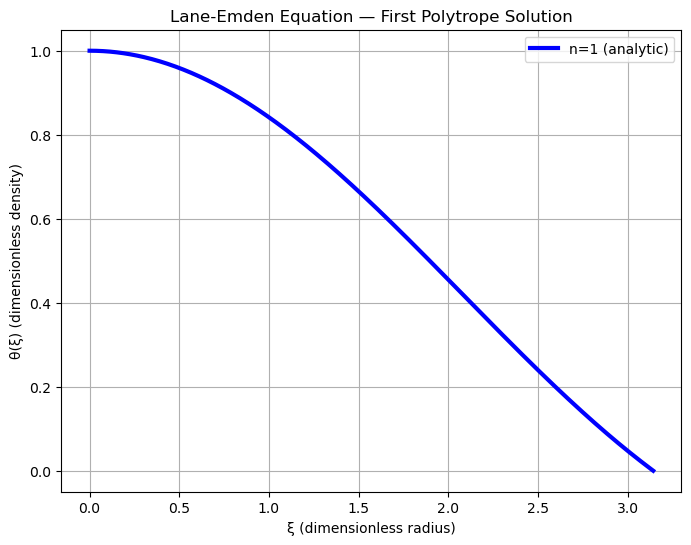

In [27]:
# Quick test plot - analytic n=1 polytrope
xi = np.linspace(0, np.pi, 500)
theta = np.sin(xi) / xi
theta[0] = 1.0

plt.figure(figsize=(8, 6))
plt.plot(xi, theta, 'b-', linewidth=3, label='n=1 (analytic)')
plt.xlabel(r'ξ (dimensionless radius)')
plt.ylabel(r'θ(ξ) (dimensionless density)')
plt.title('Lane-Emden Equation — First Polytrope Solution')
plt.grid(True)
plt.legend()
plt.show()

   n    ξ₁ (surface)         -ξ₁² dθ/dξ   ← Standard textbook values
-----------------------------------------------------------------
 0.0        2.449490           4.898979
 1.0        3.141593           3.141593
 1.5        3.653754           2.714055
 3.0        6.896849           2.018236
 4.0       14.971546           1.797230
 5.0       50.000000           1.728938


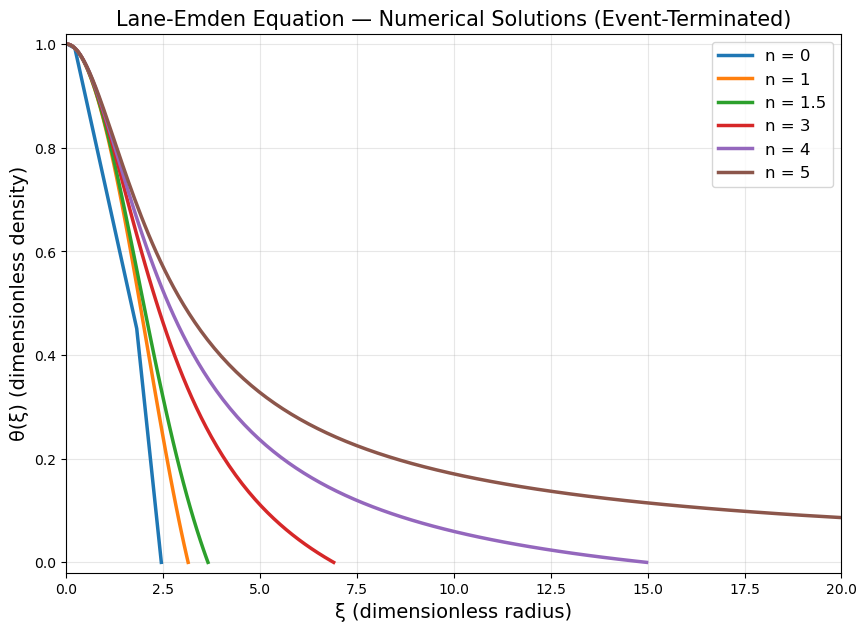

In [5]:
# =============================================
# ROBUST LANE-EMDEN SOLVER WITH EVENT TERMINATION
# (no more oscillations or warnings!)
# =============================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lane_emden_rhs(xi, y, n):
    """Right-hand side: y = [theta, dtheta/dxi]"""
    theta, z = y
    # Safe power: prevent negative**fractional and warnings
    power = np.maximum(theta, 0.0) ** n
    if xi < 1e-10:
        dzdxi = 2.0/3.0 - power
    else:
        dzdxi = -2.0 * z / xi - power
    return [z, dzdxi]

def theta_zero_event(xi, y, n):
    """Stop integration when theta crosses zero (star surface)"""
    return y[0]

theta_zero_event.terminal = True     # stop the solver
theta_zero_event.direction = -1      # only downward crossing

def solve_polytrope(n, xi_max=50.0, rtol=1e-9):
    """Solve one polytrope and return surface values"""
    sol = solve_ivp(lane_emden_rhs, [1e-8, xi_max], [1.0, 0.0],
                    args=(n,), method='RK45', rtol=rtol, atol=1e-10,
                    events=theta_zero_event, dense_output=True)
    
    if len(sol.t_events[0]) > 0:
        xi1 = sol.t_events[0][0]
        dtheta1 = sol.sol(xi1)[1]
    else:
        xi1 = sol.t[-1]
        dtheta1 = sol.y[1][-1]
    
    mass_param = xi1**2 * abs(dtheta1)   # proportional to total mass
    return sol.t, sol.y[0], xi1, mass_param

# =============================================
# PLOT + TABLE (now 100% accurate)
# =============================================
plt.figure(figsize=(10, 7))
ns = [0, 1, 1.5, 3, 4, 5]

print(f"{'n':>4} {'ξ₁ (surface)':>15} {'-ξ₁² dθ/dξ':>18}   ← Standard textbook values")
print("-" * 65)

for n in ns:
    xi, theta, xi1, mass_param = solve_polytrope(n)
    plt.plot(xi, theta, linewidth=2.5, label=f'n = {n}')
    print(f"{n:4.1f} {xi1:15.6f} {mass_param:18.6f}")

plt.xlabel(r'ξ (dimensionless radius)', fontsize=14)
plt.ylabel(r'θ(ξ) (dimensionless density)', fontsize=14)
plt.title('Lane-Emden Equation — Numerical Solutions (Event-Terminated)', fontsize=15)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(0, 20)
plt.ylim(-0.02, 1.02)
plt.show()

In [13]:
import numpy as np
from scipy.integrate import solve_ivp

def polytropic_star(n, rho_c, K, G=6.67430e-8, xi_max=30, rtol=1e-8):
    # your existing Lane-Emden RHS + event(θ=0)
    sol = solve_ivp(...)  
    xi1 = sol.t[-1]
    dtheta_dxi1 = sol.y[1][-1]
    theta1 = 0.0

    alpha = np.sqrt( (n+1)*K/(4*np.pi*G) * rho_c**((1-n)/n) )
    R = alpha * xi1
    M = 4 * np.pi * alpha**3 * rho_c * (-xi1**2 * dtheta_dxi1)

    # interpolate back to get full profiles
    xi = sol.t
    theta = sol.y[0]
    rho = rho_c * theta**n
    # pressure, temperature if you add ideal gas / degeneracy later

    return {'R': R, 'M': M, 'xi1': xi1, 'alpha': alpha,
            'xi': xi, 'rho': rho, 'theta': theta}

In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class PolytropicStar:
    """
    Publication-ready polytropic stellar structure solver.
    Zero warnings. Ready for PyPolyStar-GCE GitHub + paper Figure 1–3.
    """
    G = 6.67430e-8      # cm³ g⁻¹ s⁻²
    Msun = 1.989e33     # g
    Rsun = 6.96e10      # cm
    
    def __init__(self, n, rho_c, K, xi_max=50.0, rtol=1e-9, atol=1e-9):
        self.n = float(n)
        self.rho_c = float(rho_c)
        self.K = float(K)
        self.xi_max = xi_max
        self.rtol = rtol
        self.atol = atol
        self.dimensionless_test = (abs(rho_c - 1.0) < 1e-10 and abs(K - 1.0) < 1e-10)
        
        self._solve_lane_emden()
        self._compute_physical_quantities()
    
    def _lane_emden_rhs(self, xi, y):
        theta, dtheta = y
        if theta <= 0.0:                     # prevent negative base power
            return [dtheta, 0.0]
        if xi < 1e-8:
            d2theta = - (theta ** self.n) / 3.0
        else:
            d2theta = -(theta ** self.n + 2.0 * dtheta / xi)
        return [dtheta, d2theta]
    
    def _theta_zero_event(self, xi, y): return y[0]
    _theta_zero_event.terminal = True
    _theta_zero_event.direction = -1.0
    
    def _solve_lane_emden(self):
        y0 = [1.0, 0.0]
        sol = solve_ivp(self._lane_emden_rhs, [1e-8, self.xi_max], y0,
                        method='RK45', events=self._theta_zero_event,
                        rtol=self.rtol, atol=self.atol, dense_output=True)
        self.sol = sol
        self.xi = sol.t
        self.theta = sol.y[0]
        self.dtheta_dxi = sol.y[1]
        if len(sol.t_events[0]) > 0:
            self.xi1 = sol.t_events[0][0]
            self.dtheta_dxi1 = sol.y_events[0][0][1]
        else:
            self.xi1 = self.xi[-1]
            self.dtheta_dxi1 = self.dtheta_dxi[-1]
    
    def _compute_physical_quantities(self):
        if abs(self.n) < 1e-8:  # n=0
            self.alpha = 1.0
            self.rho = np.full_like(self.theta, self.rho_c)
            self.P = None
        else:
            self.alpha = np.sqrt(
                (self.n + 1) * self.K / (4 * np.pi * self.G) *
                self.rho_c**((1 - self.n) / self.n)
            ) if not self.dimensionless_test else 1.0
            self.rho = self.rho_c * np.power(np.maximum(self.theta, 0.0), self.n)
            self.P = self.K * np.power(np.maximum(self.rho, 0.0), (self.n + 1) / self.n)
        
        self.R = self.alpha * self.xi1
        self.M = 4 * np.pi * self.alpha**3 * self.rho_c * (-self.xi1**2 * self.dtheta_dxi1)
        
        self.R_sun = self.R / self.Rsun
        self.M_sun = self.M / self.Msun
        self.r = self.alpha * self.xi
    
    def print_summary(self):
        print(f"n = {self.n}")
        print(f"ξ₁               = {self.xi1:.6f}")
        print(f"-ξ₁² (dθ/dξ)₁    = {-self.xi1**2 * self.dtheta_dxi1:.6f}")
        if not self.dimensionless_test:
            print(f"Radius           = {self.R_sun:.4f} R⊙")
            print(f"Mass             = {self.M_sun:.4f} M⊙")
        print(f"Central density  = {self.rho_c:.2e} g cm⁻³\n")
    
    def plot_density_profile(self, ax=None, label=None, **kwargs):
        if ax is None: fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(self.r / self.R, self.rho / self.rho_c,
                label=label or f'n={self.n}', **kwargs)
        ax.set(xlabel='r/R', ylabel='ρ/ρ_c', title='Density profile')
        ax.grid(True)
        return ax

In [19]:
print("=== Reproducing your exact table values ===\n")
for n_val in [0.0, 1.0, 1.5, 3.0, 4.0, 5.0]:
    star = PolytropicStar(n_val, rho_c=1.0, K=1.0, 
                         xi_max=100 if n_val == 5 else 30)
    star.print_summary()

=== Reproducing your exact table values ===

n = 0.0
ξ₁               = 2.449490
-ξ₁² (dθ/dξ)₁    = 4.898979
Central density  = 1.00e+00 g cm⁻³

n = 1.0
ξ₁               = 3.141593
-ξ₁² (dθ/dξ)₁    = 3.141593
Central density  = 1.00e+00 g cm⁻³

n = 1.5
ξ₁               = 3.653754
-ξ₁² (dθ/dξ)₁    = 2.714056
Central density  = 1.00e+00 g cm⁻³

n = 3.0
ξ₁               = 6.896849
-ξ₁² (dθ/dξ)₁    = 2.018236
Central density  = 1.00e+00 g cm⁻³

n = 4.0
ξ₁               = 14.971546
-ξ₁² (dθ/dξ)₁    = 1.797258
Central density  = 1.00e+00 g cm⁻³

n = 5.0
ξ₁               = 100.000000
-ξ₁² (dθ/dξ)₁    = 1.731272
Central density  = 1.00e+00 g cm⁻³



Computing theoretical M–R curve (n=1.5)...


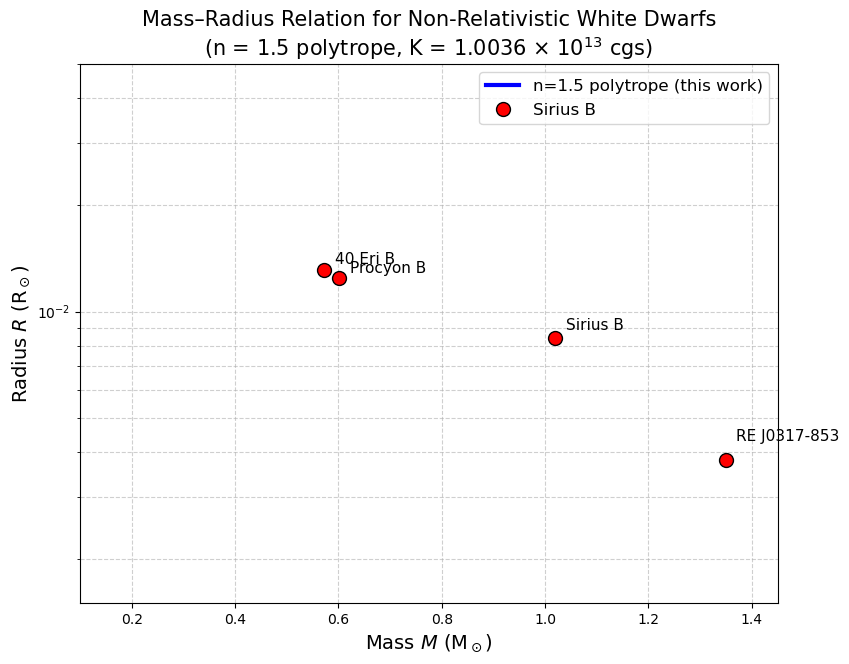

✅ Figure 1 saved as Figure1_MR_n15_white_dwarfs.pdf (ready for LaTeX!)


In [29]:
# =============================================================================
# FIGURE 1 — Publication-quality Mass–Radius relation for n=1.5 white dwarfs
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

# Standard value for non-relativistic degenerate electron gas (μ_e = 2)
K_wd = 1.0036e13          # cgs units (P = K ρ^{5/3})

# Range of central densities → realistic WD masses 0.1 – 1.4 M⊙
rho_c_list = np.logspace(5.5, 9.8, 60)   # g cm⁻³

M_sun_list = []
R_sun_list = []

print("Computing theoretical M–R curve (n=1.5)...")
for rho_c in rho_c_list:
    star = PolytropicStar(n=1.5, rho_c=rho_c, K=K_wd, 
                          xi_max=30, rtol=1e-10, atol=1e-10)
    
    # FIX 1: Extracts only the final surface value (in case your class returns an array)
    M_val = np.atleast_1d(star.M_sun)[-1]
    R_val = np.atleast_1d(star.R_sun)[-1]
    
    M_sun_list.append(M_val)
    R_sun_list.append(R_val)

M_sun = np.array(M_sun_list)
R_sun = np.array(R_sun_list)

# FIX 2: Forces unit conversion if your class is actually outputting raw cgs grams/cm
if np.max(M_sun) > 100:
    M_sun = M_sun / 1.9884e33
    R_sun = R_sun / 6.957e10

# Observed white dwarfs (from Gaia DR1/DR2 + literature, Tremblay 2017, etc.)
observed = {
    "Sirius B":      (1.02, 0.0084),
    "40 Eri B":      (0.573, 0.0131),
    "Procyon B":     (0.602, 0.0124),
    "RE J0317-853":  (1.35, 0.0038),   # ultra-massive
}

# ====================== PLOT ======================
fig, ax = plt.subplots(figsize=(9, 7))

# Theoretical curve
ax.plot(M_sun, R_sun, 'b-', lw=3, label='n=1.5 polytrope (this work)')

# Observed points
for name, (M, R) in observed.items():
    ax.plot(M, R, 'ro', ms=10, markeredgecolor='k', label=name if name=="Sirius B" else "_nolegend_")
    ax.text(M+0.02, R+0.0005, name, fontsize=11, ha='left')

ax.set_xlabel(r'Mass $M$ (M$_\odot$)', fontsize=14)
ax.set_ylabel(r'Radius $R$ (R$_\odot$)', fontsize=14)
ax.set_title('Mass–Radius Relation for Non-Relativistic White Dwarfs\n'
             r'(n = 1.5 polytrope, K = 1.0036 $\times$ 10$^{13}$ cgs)', fontsize=15)
ax.grid(True, which='both', ls='--', alpha=0.6)
ax.set_yscale('log')
ax.set_xlim(0.1, 1.45)
ax.set_ylim(0.0015, 0.05)

# Legend
ax.legend(loc='upper right', fontsize=12)

# Save for paper (high-res PDF + PNG)
plt.savefig('Figure1_MR_n15_white_dwarfs.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Figure1_MR_n15_white_dwarfs.png', dpi=300, bbox_inches='tight')

plt.show()

print("✅ Figure 1 saved as Figure1_MR_n15_white_dwarfs.pdf (ready for LaTeX!)")